# Setup and goal

We consider the multinomial classification problem in $K$ dimensions. A pair of jointly distributed random variables $(X,Y)$ takes values on $\mathcal X \times \{1,\ldots,K\}$. We are given $N = \sum_{k=1}^K n_k$ observations $(x_i, y_i)$, where $n_k$ is the number of observations of class $k$.

Assume we train a classifier $\vec f: \mathcal X \to [0,1]^K$. More precisely, the image of $\vec f$ is $K-1$-dimensional **(closed) simplex** $\Delta_{K-1} \subset [0,1]^K$, where

$$\Delta_{K-1} := \left\{p \in [0,1]^K: \sum_{i=1}^K p_i = 1\right\},$$

so that for any $x \in \mathcal X$, $\vec f(x)$ is a probability vector where each component $\vec f(x)_k$ denotes the probability that this instance belongs to class $k$,

We want to find a **generalized ROC AUC to describe $\vec f$'s behavior**, while still a single scalar.

# GeoAUC

Fix a given metric $d: \Delta_{K-1} \times \Delta_{K-1} \to \mathbb R_+$ on the simplex, treated here as a metric space. It is important that this metric is defined within the closed simplex in order to avoid divergent limiting behavior as we approach the edges.

Denote the $a$-th vertex of the simplex as $\vec a$, where $(\vec a)_i = \delta_{ia}$. We might argue that a good classifier is one which lands points in class $a$ close to vertex $\vec a$. More precisely, given any random point $x$ in class $a$ and another point $x'$ in class $b$, we may wish that $f\vec (x)$ is closer to $\vec a$ than $\vec f(x')$ is, and, similarly, that $\vec f(x')$ is closer to $\vec b$ than $\vec f(x)$ is. Formally, writing the point-vertex distance as 

$$d_a(x) \equiv d(\vec f (x), \vec a)$$

then we want

$$d_a(x) \leq d_a(x'),\qquad d_b(x) \geq d_b(x')$$

Another way to put this is that, for a fixed class $a$ and a point $x$ in this class, we want to reward a model for which $d_a(x) \leq d_a(x')$ for any $x'$ *not* in class $a$.

This motivates the following definition. Let $a, b \in \{1,\cdots, K\}$ be different classes. Then,

$$\boxed{A_{ab} := \frac{1}{n_a n_b} \sum_{i: y_i = a} \; \sum_{j:y_j = b} 1_{d_a(x_i)\leq d_a(x_j)}}$$

is a natural generalization of the Mann-Whitney-Wilcoxon U-statistic for the ROC AUC; indeed, for $K=2$, it is easy to show that it reduces to standard ROC AUC.

> Notice that $A_{ab} \neq A_{ba}$ in general. Indeed, one can show that 
$$\boxed{\mathbb E[A_{ab}] = \mathbb P(d_a(X) \leq d_a(X')|Y=a, Y'=b)}$$

With this definition, we may define

$$\boxed{\mathrm{GeoAUC} := \frac{1}{K(K-1)} \sum_{a=1}^K \sum_{b=1\\b\neq a}^K A_{ab}}$$

### Dependence on the choice of metric

As we have defined it, GeoAUC depends on the choice of a metric $d$; this is similar to how Kleiman & Page (2019) require a cost matrix $A$ for their $\mathrm{AUC}_\mu$ metric.

> However, while the choice of matrix (which is equivalent to a choice of thresholds) is arbitrary in their case, we argue that a choice of distance is much more general and requires no previous knowledge of thresholds or the structure of the data, eg. the class imbalance.

**For $K=2$**: the 1-simplex $\Delta_1$ is just the a line segment endowed with a metric structure. Here, for simplicity, write our classes as $\{0,1\}$ instead of $\{1,2\}$ (so that the vector for class 0 corresponds to the point $[0,1]$ and class 1 corresponds to $[1,0]$). Then

$$\begin{align*}
\mathbb E[\mathrm{GeoAUC}] &= \frac{1}{2} (\mathbb E[A_{01}] + \mathbb E[A_{10}])\\
&= \frac 12 (\mathbb P(d_0(X) \leq d_0(X')|Y=0, Y'=1) + \mathbb P(d_1(X) \leq d_1(X')|Y=1, Y'=0))
\end{align*}$$


If we can prove that for any $X$, $d_1(X) = d(0,1) - d_0(X)$ then we are done; this simplifies one of the probability terms into the other one, and we retrieve the ROC AUC. For this $K=2$ case, this is true; it happens because this space is one-dimensional. It is easy to show for the familiar Euclidean distance, where $d(0,1) = \sqrt 2$; the proof is a bit harder for, say, the Fisher-Hotelling-Rao distance introduced in Nielsen & Sun (2021).

*Exercise*: For any two points $\vec p, \vec q \in \Delta_{K-1}$, the Fisher-Hotelling-Rao distance is defined as

$$\boxed{d_\mathrm{FHR}(\vec p, \vec q) = 2 \arccos \left(\sum_{i=1}^K \sqrt{p_i q_i}\right)}$$

Prove that, for $K=2$, for any $\vec p = [p, 1-p]$, we have $d(\vec 0, \vec p) + d(\vec 1, \vec p) = \pi$.

In [ ]:
# any distance function must take a (n,K) (K: categories, n: datapoints) array
# and return an (n,) array with distances from vertex i, with coordinates delta_ik

@jit(nopython=True)
def squared_euclidean_dist(vec_p, i):
    delta = np.zeros_like(vec_p)
    delta[:,i] = 1
    return np.sum((vec_p - delta)**2, axis=1)

# compile, this is a norm squared
_ = squared_euclidean_dist(np.array([[1,2,3], [2,3,4]]),1)

@jit(nopython=True)
def fisher_hotelling_rao_dist(vec_p, i):
    # equation 1 in https://arxiv.org/pdf/1704.00454.pdf
    # for the case when q_k = delta_ik. Only one term in the sum survives
    
    return 2*np.arccos(np.sqrt(vec_p[:,i]))

_ = fisher_hotelling_rao_dist(np.array([[1,2,3], [2,3,4]]),1)

def geo_auc(y_true, y_probs,
            metric=squared_euclidean_dist):
    from itertools import product
    import pandas as pd

    labels = np.unique(y_test)
    n_labels = len(labels)
    
    # probabilities
    p = {i: y_probs[y_true==i] for i in labels}
    n = {i: len(p[i]) for i in labels}
    
    # distance matrices
    d = {(i,a): metric(p[i], a) for i, a in product(labels, labels)}

    S, Sab = 0, 0
    for a, b in product(labels, labels):
        if a == b:
            continue
        else:
            D = pd.DataFrame(list(product(d[(a,a)], d[(b,a)])), columns=['_ia', '_ja'])
            Sab = (D['_ia'] <= D['_ja']).sum() /(n[a]*n[b])
            S += Sab
            print(f"S_{a},{b} = {round(Sab,4)}")
            
    S *= 1/(n_labels * (n_labels-1))
    return S

# References

[1] Kleiman, Page (2019): https://proceedings.mlr.press/v97/kleiman19a.html

[2] Nielsen & Sun (2021): https://arxiv.org/pdf/1704.00454.pdf

## Appendix: Visualizing the Fisher-Hotelling-Rao metric

In [79]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def euclidean_to_simplex(probs):
    x, y, z = probs[:,0], probs[:,1], probs[:,2]
    u = (-x+y)/np.sqrt(2)
    v = (-x-y+2*z+1)/np.sqrt(6)
    return np.array([u, v]).T

def simplex_to_euclidean(prob_2d):
    u, v = prob_2d[:,0], prob_2d[:,1]
    x = 1/2 - (u + v/np.sqrt(3))/np.sqrt(2)
    y = u/np.sqrt(2) - v/np.sqrt(6) + 1/2
    z = 1 - x - y
    return np.array([x, y, z]).T

#test
input_array = np.array([[0.1, 0.8, 0.1], [0.2, 0.5, 0.3], [1, 0, 0], [0, 1, 0]])
assert np.all(np.isclose(simplex_to_euclidean(euclidean_to_simplex(input_array)), input_array))

Let us plot a few balls in the 2D simplex $\Delta_2$, which shows up in a 3-class classification problem.

To do that, we will solve the equation $d_\mathrm{FHR}(\vec p_0, \vec p) = \epsilon$ for the variable $\vec p$. The main realization is that this equation can be solved in a few steps:

* First, removing the arccos, we have $\sum_{i=1}^K \sqrt{p_i (p_0)_i} = \cos(\epsilon/2)$. If we call 

  $$\mathbf n \equiv \sqrt{p_0} \; \mbox{(element-wise)}$$
  $$\mathbf{u} \equiv \sqrt{p} \; \mbox{(element-wise)}$$
  
  then the equation reduces to
  
  $$\begin{cases}
  \mathbf n \cdot \mathbf u &=  \cos   \displaystyle  \frac{\epsilon}{2} \\
  \mathbf u^2 &= 1
  \end{cases} \qquad (*)$$
  
  (we use boldface for "square-rooted" vectors as to not confuse them with "real-probability space" vectors) Notice that both $\mathbf n$ and $\mathbf u$ have unit length under the regular Euclidean norm. This will be important later on.
  

* How to solve an equation such as ($*$)? Notice that it is of the form $\mathbf a \cdot \mathbf x = b$, where $\mathbf a$ is a fixed vector and $b$ is a fixed scalar. One way is to choose a coordinate frame where the known vector $n$ is parallel to the $z$ axis. In this frame, $\mathbf n= (0,0,1)$ and the scalar product gives

  $$\cos\frac\epsilon 2 = \mathbf n \cdot \mathbf u  = |\mathbf n| |\mathbf u| \cos \theta_{n,u} = \cos \theta_{n,u}, $$
  so we find $\epsilon/2$ is just the angle between $\mathbf n$ and $\mathbf u$. Since $\mathbf n$ is just the versor in the $z$ direction, this means that the solutions $\mathbf u$ describe a cone around the $z$ axis with an angle of $\epsilon/2$ with the vertical. In spherical coordinates, this gives a family of solutions, one for each $\varphi \in [0,2\pi[$:

$$\mathbf u(\varphi)_\text{rotated}
= \begin{bmatrix}
\sin \frac\epsilon 2 \cos \varphi\\
\sin \frac \epsilon 2 \sin \varphi\\
\cos \frac \epsilon 2
\end{bmatrix}
$$



* In practice, we need to be able to go back and forth between the ambient Cartesian coordinates and these where the $z$ axis is parallel to the vector $\mathbf n$. [One can show](https://math.stackexchange.com/questions/542801/rotate-3d-coordinate-system-such-that-z-axis-is-parallel-to-a-given-vector) that we can go back to the original coordinates via the following procedure. Let
  - $\theta = \arccos \mathbf n_z$ (ie. the $z$ component of the $\mathbf n$ vector in the original, non-rotated cordinates)
  - $\mathbf b = \displaystyle \frac{\mathbf k \times \mathbf n}{|\mathbf k \times \mathbf n|}$
  - $q_0 = \cos\displaystyle \frac\theta 2$, $q_i = b_i \sin\displaystyle \frac\theta 2$ (for $i \in \{1,2,3\}$)

  If we then define the matrix
  
  $$Q = \begin{bmatrix}
    q_0^2 + q_1^2-q_2^2-q_3^2 &  2(q_1 q_2-q_0q_3) &  2(q_1q_3+q_0 q_2)\\
    2(q_2q_1 + q_0q_3 & q_0^2-q_1^2+q_2^2-q_3^2    &  2(q_2 q_3-q_0 q_1\\
    2(q_3q_1 - q_0q_2)& 2(q_3 q_2+q_0 q_1          & q_0^2-q_1^2-q_2^2+q_3^2
    \end{bmatrix}$$

  then we can convert from rotated to original coordinates via $\mathbf u_\text{original} = Q \mathbf u_\text{rotated}$.
  
* Finally, we want to go back to probabilities; since we took square roots before, we get back to probabilities via squaring:

$$\vec p(\varphi) = (Q  \mathbf u(\varphi)_\text{rotated})^2 \quad\mbox{(element-wise)} $$

We implement this procedure below; we open up the calculations for $Q$ a bit more in order too simplify them.

In [324]:
def rotation_function_from_3d_prob_vector(p0):

    assert p0.shape == (3,), "Invalid shape for p0"
    assert p0.sum() == 1, "p0 not valid probability vector"

    n = np.sqrt(p0)
    nx, ny, nz = n[0], n[1], n[2]

    q0 = np.sqrt(0.5*(1+nz))
    q1 = - ny / np.sqrt(2*(1+nz))
    q2 =   nx / np.sqrt(2*(1+nz))

    Q = np.array([
        [q0**2 + q1**2-q2**2, 2*q1*q2, 2*q0*q2],
        [2*q2*q1, q0**2-q1**2+q2**2, -2*q0*q1],
        [-2*q0*q2, 2*q0*q1, q0**2-q1**2-q2**2]
    ])

    def rotate_back(vec):
        return Q@vec
    
    return rotate_back
# def rotation_function_from_3d_prob_vector(p0):

#     assert p0.shape == (3,), "Invalid shape for p0"
#     assert p0.sum() == 1, "p0 not valid probability vector"

#     n = np.sqrt(p0)
#     k = np.array([0,0,1])
#     theta = np.arccos(n[2])
#     b = np.cross(k, n)/np.linalg.norm(np.cross(k, n))

#     q0 = np.cos(theta/2)
#     q1 = np.sin(theta/2)*b[0]
#     q2 = np.sin(theta/2)*b[1]
#     q3 = np.sin(theta/2)*b[2]

#     Q = np.array([
#         [q0**2 + q1**2-q2**2-q3**2, 2*(q1*q2-q0*q3), 2*(q1*q3+q0*q2)],
#         [2*(q2*q1 + q0*q3), q0**2-q1**2+q2**2-q3**2, 2*(q2*q3-q0*q1)],
#         [2*(q3*q1 - q0*q2), 2*(q3*q2+q0*q1), q0**2-q1**2-q2**2+q3**2]
#     ])

#     def rotate_back(vec):
#         return Q@vec
    
#     return rotate_back
     
def fhr_ball(p0, r, circle_steps=4):
    
    # creating circle
    phi = np.linspace(0, 2*np.pi, circle_steps)
    eps_over_2 = 0.5*r*np.ones_like(phi)
    
    # to avoid numerical issues with large angles, we will need some cuts
#     eps_over_2 = np.clip(eps_over_2, 0, np.pi/2)
    
    points = np.array([np.sin(eps_over_2)*np.cos(phi),
                       np.sin(eps_over_2)*np.sin(phi), 
                       np.cos(eps_over_2)]).T
    
    
    transform = rotation_function_from_3d_prob_vector(p0)
    
    euclidean = np.array([transform(point) for point in points])
    euclidean = np.abs(euclidean)**2.0 # pra voltar a serem probabilidades

    return euclidean, transform

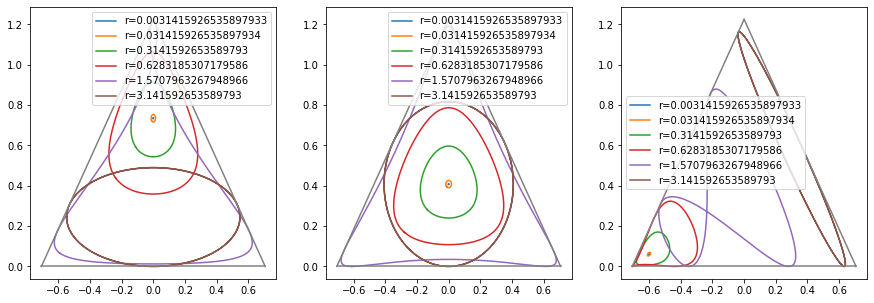

In [325]:
def plot_balls(p0, radii, ax):
    assert p0.shape == (3,), "Invalid shape for p0"
    assert p0.sum() == 1, "p0 not valid probability vector"

    for r in radii:
        ball, transform = fhr_ball(p0, r=r, circle_steps=500)
        ball_simplex = euclidean_to_simplex(ball)
        ax.plot(ball_simplex[:,0], ball_simplex[:,1], label=f"{r=}")

    ax.plot([-1/np.sqrt(2), 0], [0, np.sqrt(3/2)], color='gray')
    ax.plot([0, 1/np.sqrt(2) ], [np.sqrt(3/2), 0], color='gray')
    ax.plot([-1/np.sqrt(2), 1/np.sqrt(2)], [0, 0], color='gray')
    ax.legend()
    
radii = np.pi/np.array([1000, 100, 10, 5, 2,1])

fig, ax = plt.subplots(figsize=(15,5), ncols=3)
plot_balls(p0=np.array([0.2, 0.2, 0.6]), radii=radii, ax=ax[0])
plot_balls(p0=np.array([0.3333, 0.3333, 0.3334]), radii=radii, ax=ax[1])
plot_balls(p0=np.array([0.90, 0.05, 0.05]), radii=radii, ax=ax[2])
plt.show()

### Are some of the weird results due to numerical instabilities? Or some actuall error in calculations?

Let us study the case in one dimension:

Fix $p_0$. The equation for the ball is 
$$2 \cos^{-1}( \sqrt{p_0 p} + \sqrt{(1-p_0)(1-p)}) = \epsilon$$

To solve this, define $\theta_0, \theta$ such that

$$p_0 = \sin^2 \theta_0, \quad p = \sin^2 \theta.$$

We assume with no loss of generality that $\theta_0$ is in $[0,\pi/2]$.

Then 

$$\sqrt{p_0 p} + \sqrt{(1-p_0)(1-p)} = \cos \theta_0 \cos \theta + \sin \theta_0 \sin \theta = \cos(\theta-\theta_0)$$

which must be equal to $\cos \epsilon/2$; but

$$\cos x = \cos a \quad \Rightarrow \quad x = 
\begin{cases} a + 2k \pi\\
\quad\mbox{or}\\
- a + 2k \pi
\end{cases}$$

from which we get
$$\theta-\theta_0 = \pm \frac{\epsilon}{2} + 2k \pi \Rightarrow\quad \theta = \theta_0 \pm \frac{\epsilon}{2} + 2k\pi, \quad k \in \mathbb Z$$

Now, we can with no loss of generality assume $\theta \in [0,\pi/2]$; hence we can only take the $k=0$ set of solutions. Hence, we can keep both $\pm$ values as long as they don't escape this interval; in other words

$$\boxed{\theta(\theta_0, \epsilon) = \mathrm{cap}\left( \theta_0 \pm \frac \epsilon 2; \mbox{low}=0; \mbox{high} = \frac \pi 2\right)}$$

To rewrite this in terms of $p$ and $p_0$, we get a solution set

$$\boxed{p \in \{\sin^2 \theta(\theta_0, \epsilon): \;\theta_0 = \arcsin \sqrt{p_0}\}}$$

In [332]:
# Example
p_0 = 0.3
theta_0 = np.arcsin(np.sqrt(p_0))

sols = []
eps_range = np.linspace(0.001, 2*np.pi, num=100)
for eps in eps_range:
    theta = np.array([np.clip(theta_0 + eps/2, 0, np.pi/2),
                       np.clip(theta_0 - eps/2, 0, np.pi/2)])
    p = np.sin(theta)**2
    sols.append(p)
    
sols = np.array(sols)

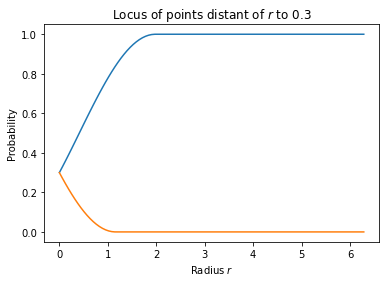

In [333]:
plt.plot(eps_range, sols[:,0])
plt.plot(eps_range, sols[:,1])
plt.xlabel('Radius $r$')
plt.ylabel('Probability')
plt.title("Locus of points distant of $r$ to 0.3")
plt.show()

See how, as we increase the radius $\epsilon$, we eventually reach plateaus at $p=0$ and $p=1$. This is expected; we can indeed get infinitely far by only asymptotically approaching the boundaries.

**However!** Notice how a naive implementation might look like. If we handn't capped the $\theta$ value, we would have gotten instead

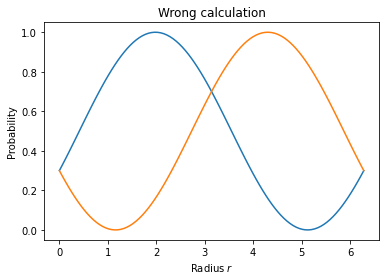

In [334]:
# Example
sols = []
eps_range = np.linspace(0.001, 2*np.pi, num=100)
for eps in eps_range:
    theta = np.array([theta_0 + eps/2, theta_0 - eps/2])  # naive implementation
    p = np.sin(theta)**2
    sols.append(p)
    
sols = np.array(sols)

plt.plot(eps_range, sols[:,0])
plt.plot(eps_range, sols[:,1])
plt.xlabel('Radius $r$')
plt.ylabel('Probability')
plt.title("Wrong calculation")
plt.show()

The issue here is that our argument grows too much. We need to be careful with the 2D implementation too.